# Evaluation and Attribution

## Packages

In [27]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# working with arrays
import numpy as np

# plotting functionality
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy import stats

# typehints
from typing import Tuple

"""
Own packages
"""
from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

from codelib.statistics.cornish_fisher import calculate_cornish_fisher_percentile

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Value at Risk

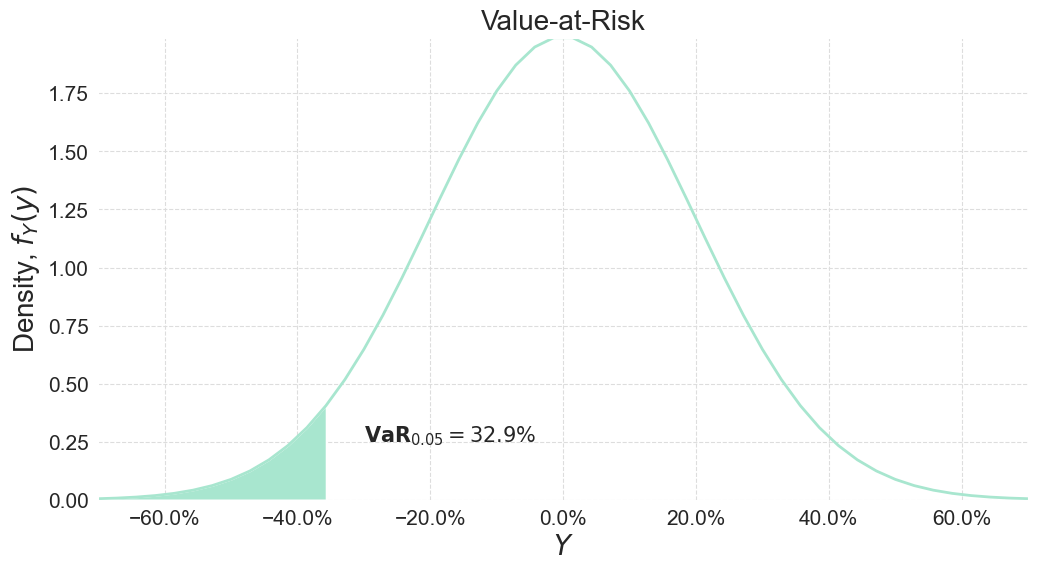

In [4]:
mu = 0.0
sigma = 0.2

# calculate 5% VaR
value_at_risk = stats.norm.ppf(0.05, loc=mu, scale=sigma)

# values for plotting the pdf
v_values = np.linspace(-0.7, 0.7)
pdf_values = stats.norm.pdf(v_values, loc=mu, scale=sigma)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(v_values, pdf_values)
ax.fill_between(v_values, pdf_values, where=v_values<value_at_risk)
ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('$Y$', size=20)
ax.set_ylabel('Density, $f_{Y}(y)$', size=20);

# add text
text_to_add =  "$\\mathbf{VaR}_{0.05}" + " = {:,.1f}\\%$".format(-value_at_risk*100)
ax.text(-0.3, 0.25, text_to_add);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

# save figure
fig.savefig("normal_value_at_risk.pdf", dpi=300, bbox_inches='tight')

### Simulation of log-normal VaR

In [11]:
"""
Define relevant information
"""

w_eq = np.array([0.5, 0.5])

mu_s = 0.06
mu_b = 0.01
sigma_s = 0.15
sigma_b = 0.075
rho = 0.2

mus = np.array([mu_s, mu_b])
vols = np.array([sigma_s, sigma_b])
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cov_mat = np.outer(vols, vols) * corr_mat

"""
Simulate
"""
num_sim = 99999
sim_log_returns = np.random.multivariate_normal(mus, cov_mat, size=num_sim)
sim_lin_returns = np.exp(sim_log_returns) - 1.0
sim_port_returns = sim_lin_returns @ w_eq

# use numpys percentile to calculate the fifth percentile (note the use of 5 and not 0.05)
value_at_risk = np.percentile(sim_port_returns, q=5)

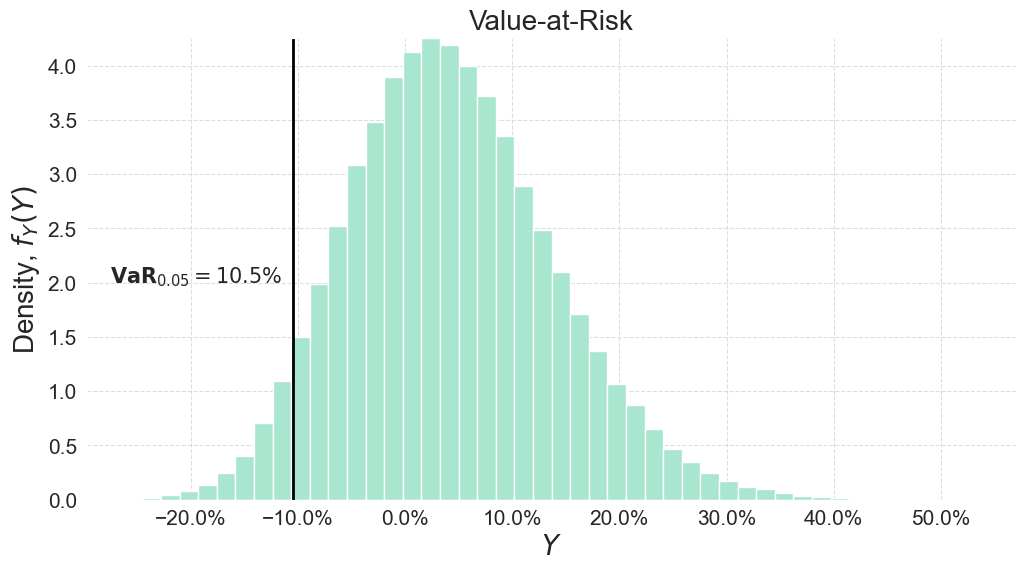

In [15]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(sim_port_returns, density=True, bins=50)
ax.axvline(value_at_risk, ymin=0, ymax=4.1, color="black")
ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('$Y$', size=20)
ax.set_ylabel('Density, $f_{Y}(Y)$', size=20);

# add text
text_to_add =  "$\\mathbf{VaR}_{0.05}" + " = {:,.1f}\\%$".format(-value_at_risk*100)
ax.text(-0.275, 2.0, text_to_add);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

# save figure
fig.savefig("log_normal_value_at_risk.pdf", dpi=300, bbox_inches='tight')

## Cond. Value at Risk

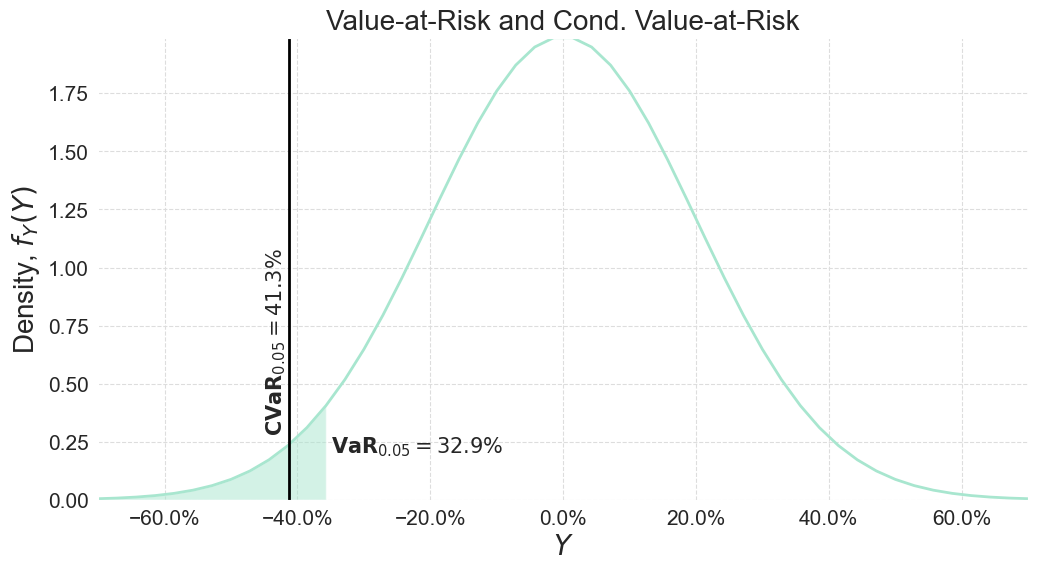

In [17]:
mu = 0.0
sigma = 0.2

# calculate 5% VaR and CVaR
value_at_risk = stats.norm.ppf(0.05, loc=mu, scale=sigma)
cond_value_at_risk = mu -  sigma*stats.norm.pdf(stats.norm.ppf(0.05)) / 0.05

# values for plotting the pdf
v_values = np.linspace(-0.7, 0.7)
pdf_values = stats.norm.pdf(v_values, loc=mu, scale=sigma)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(v_values, pdf_values)
ax.fill_between(v_values, pdf_values, where=v_values<value_at_risk, alpha=0.5)
ax.axvline(cond_value_at_risk, ymin=0, ymax=4.1, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$Y$', size=20)
ax.set_ylabel('Density, $f_{Y}(Y)$', size=20);

# add text
text_to_add =  "$\\mathbf{VaR}_{0.05}" + " = {:,.1f}\\%$".format(-value_at_risk*100)
text_to_add_2 =  "$\\mathbf{CVaR}_{0.05}" + " = {:,.1f}\\%$".format(-cond_value_at_risk*100)
ax.text(-0.35, 0.20, text_to_add);
ax.text(-0.45, 0.3, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)


# save figure
fig.savefig("normal_cond_value_at_risk.pdf", dpi=300, bbox_inches='tight')

## Risk attribution

### Stock-bond portfolio example

In [18]:
"""
Define relevant information
"""

w_eq = np.array([0.5, 0.5])

sigma_s = 0.15
sigma_b = 0.075
rho = 0.2

vols = np.array([sigma_s, sigma_b])
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cov_mat = np.outer(vols, vols) * corr_mat

"""
Define a function that calculates portfolio standard deviation
"""

def portfolio_std(weights: np.ndarray, cov_matrix: np.ndarray) -> float:

    """
    Function that returns the standard deviation of the portfolio

    Parameters
    ----------
    weights:
        Portfolio weights
    cov_matrix:
        Covariance matrix

    Returns
    -------
    float
        Standard deviation of portfolio
    """

    return np.sqrt(weights @ cov_matrix @ weights)

"""
Calculate diversification benefit
"""
total_port_risk = portfolio_std(w_eq, cov_mat)
div_benefit = total_port_risk - w_eq @ vols

print('The diversification benefit is equal to {:.2f}%'.format(div_benefit * 100))

The diversification benefit is equal to -2.22%


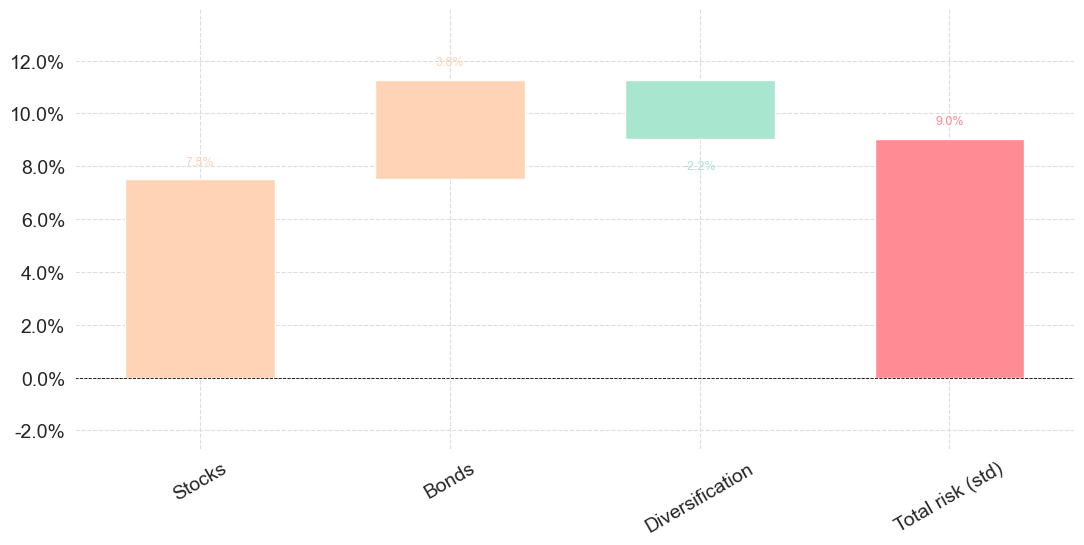

In [25]:
"""
Plot a waterfall chart with risk decomposition
"""
plt.rcParams.update({'font.size':14})

fig, ax = risk_waterfall_chart(vols * w_eq * 100, total_port_risk*100, names=["Stocks", "Bonds"],
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification");

fig.set_size_inches(12, 6)

# save figure
fig.savefig("waterfall_stock_bond_std.pdf", dpi=300, bbox_inches='tight')

In [28]:
def calculate_marginal_risks(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:

    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_matrix:
        Covariance matrix

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights

    return inner_derivative / total_risk

def calculate_risk_contributions(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:

    """
    Function that calculates risk contributions

    Parameters
    ----------
    weights:
        Portfolio weights
    cov_matrix:
        Covariance matrix

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks(weights, cov_matrix)

    return weights * mr

risk_contrib = calculate_risk_contributions(w_eq, cov_mat)
print("Risk contribution:")
print("Stocks: {:.2f}%'".format(risk_contrib[0] * 100))
print("Bonds: {:.2f}%'".format(risk_contrib[1] * 100))

Risk contribution:
Stocks: 6.85%'
Bonds: 2.18%'


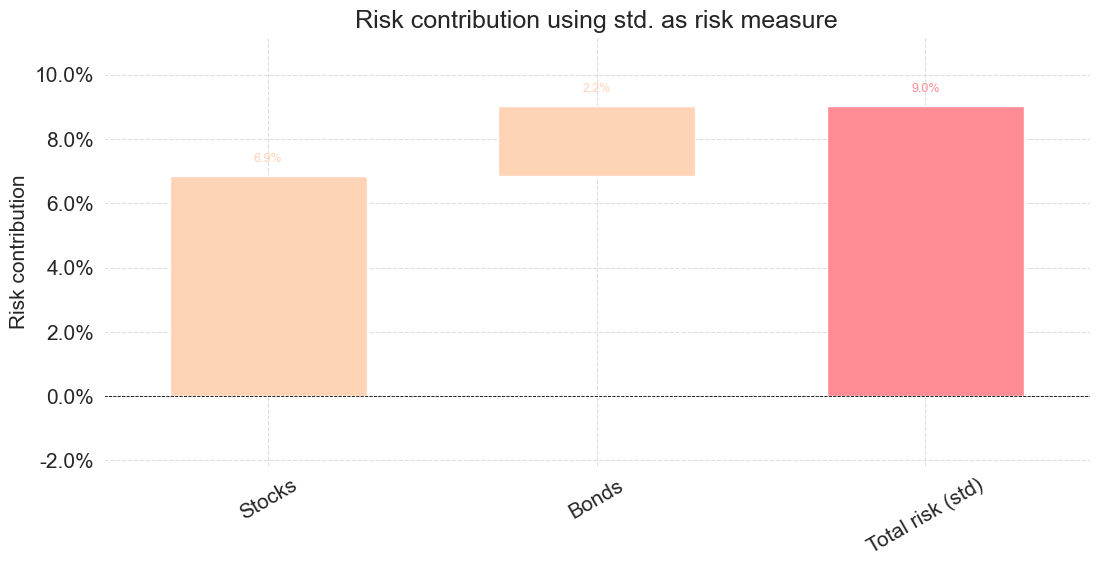

In [30]:
fig, ax = waterfall_chart(values=risk_contrib * 100,
                          labels=["Stocks", "Bonds"],
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution", title="Risk contribution using std. as risk measure")

fig.set_size_inches(12, 6);

fig.savefig("waterfall_stock_bond_risk_contribution_std.pdf", dpi=300, bbox_inches='tight')